# FEATURE ENGINEERING


## 0. Import Dependencies

In [67]:
import pandas as pd
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
#!pip install plotly
import plotly.express as px 

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from IPython.display import display


In [2]:
SEED = 42
np.random.seed(SEED)

## 1. Set Up

### 1.1 File Paths

In [3]:
BASE_DIR = Path(r"C:/Users/black/Documents/Ironhack/final_project")
RAW_DIR = BASE_DIR / "data" / "raw"
CLEAN_DIR = BASE_DIR / "data" / "clean"
PROCESSED_DIR = BASE_DIR / "data" / "processed"
FEATENG_DIR = BASE_DIR / "data" / "feat_eng"

RAW_DIR.mkdir(parents=True, exist_ok=True)
CLEAN_DIR.mkdir(parents=True, exist_ok=True)
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
FEATENG_DIR.mkdir(parents=True, exist_ok=True)

### 1.2 Plot Design


In [4]:
# seaborn theme
sns.set_theme(style="whitegrid", palette="pastel")

# matplotlib general settings
plt.rcParams['figure.figsize'] = (5, 3)  # default figure size
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['grid.alpha'] = 0.3
# reproducibility
RANDOM_STATE = SEED
# custom color palette
colors = {
    'rosa': '#F4A3B8',     
    'pink': '#FF69B4',     
    'orange': '#FFA500',   
    'yellow': '#FFD700',   
    'red': '#FF4500',      
    'lilac': '#C8A2C8',    
}

sns.set_palette(list(colors.values()))
# display
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)
pd.set_option('display.float_format', '{:.2f}'.format)

## 2. Load Data 

In [56]:
individual_df = pd.read_csv(r"data\feat_eng\individual_df.csv")
violence_df = pd.read_csv(r"data\feat_eng\violence_df.csv")
global_df = pd.read_csv(r"data\feat_eng\global_df.csv")

## 3. Individual Dataset


**Target Variable** : VIOLENCE (yes/no == 1/0)

*Which individual factors lead to experiencing violence as a woman?*

In [57]:
# chech unique values for encoding types, etc. 
individual_df.nunique()

age                39
education           4
employment          3
income             23
marital_status      2
violence_binary     2
vawg_rate           7
dtype: int64

In [58]:
# re-check if missing data 
individual_df.isna().sum()

age                0
education          0
employment         0
income             0
marital_status     0
violence_binary    0
vawg_rate          0
dtype: int64

In [59]:
# rename target column
individual_df = individual_df.rename(columns={"violence_binary" : "violence"})

**Feature Engineering Plan**

- encode:
    - education (ordinal, as natural order)
    - employment (one hot)
    - marital status (binary)

- normalize numeric features
    - age -> z-score
    - income -> log-transform (skewed!) + z-score

- interaction features
    - age × marital_status
    - education × employment
    - employment × marital_status
    - income × education

In [60]:
def feature_engineer_vawg(df_eng):
    """
    Feature engineering pipeline for VAWG (Violence Against Women) prediction.
    Focuses on high-priority features.
    """
     
    # Education: Ordinal encoding (inherent order)
    education_order = {
        'none': 0,
        'primary': 1,
        'secondary': 2,
        'higher': 3,
        'tertiary': 3  
    }
    df_eng['education_ordinal'] = df_eng['education'].str.lower().map(education_order)
    
    # Employment: One-hot encoding (only 3 categories)
    df_eng = pd.get_dummies(df_eng, columns=['employment'], prefix='emp', drop_first=False)
    
    # Handle potential column name variations
    if 'emp_unemployed' not in df_eng.columns:
        # Create from available columns
        emp_cols = [col for col in df_eng.columns if col.startswith('emp_')]
        if emp_cols:
            df_eng['emp_unemployed'] = (~df_eng[emp_cols].any(axis=1)).astype(int)
    
    # Marital status: Binary encoding
    df_eng['is_married'] = df_eng['marital_status'].str.lower().isin(['married', 'living_together']).astype(int)
    
    # Income: Log transformation (handles skewness)
    df_eng['income_log'] = np.log1p(df_eng['income'])
    
    # Standardization
    scaler = StandardScaler()
    df_eng['age_scaled'] = scaler.fit_transform(df_eng[['age']])
    df_eng['income_scaled'] = scaler.fit_transform(df_eng[['income_log']])
    
    # Vulnerability markers for VAWG
    df_eng['young_unmarried'] = ((df_eng['age'] < 25) & (df_eng['is_married'] == 0)).astype(int)
    
    df_eng['low_education_unemployed'] = (
        (df_eng['education_ordinal'] <= 1) & 
        (df_eng['emp_unemployed'] == 1)
    ).astype(int)
    
    df_eng['married_unemployed'] = (df_eng['is_married'] * df_eng['emp_unemployed']).astype(int)
    
    # Economic vulnerability
    df_eng['age_income'] = df_eng['age_scaled'] * df_eng['income_scaled']
    df_eng['education_income'] = df_eng['education_ordinal'] * df_eng['income_scaled']
     
    # Age groups (non-linear risk patterns)
    df_eng['age_group_young'] = (df_eng['age'] < 25).astype(int)
    df_eng['age_group_middle'] = ((df_eng['age'] >= 25) & (df_eng['age'] < 35)).astype(int)
    # Reference group: 35+ (implicit)
    
    # Economic vulnerability index (0-3 score)
    df_eng['economic_vulnerability'] = (
        (df_eng['income'] < df_eng['income'].quantile(0.25)).astype(int) +
        (df_eng['emp_unemployed'] == 1).astype(int) +
        (df_eng['education_ordinal'] <= 1).astype(int)
    )
    
    # Empowerment proxy (education + employment)
    df_eng['empowerment_score'] = df_eng['education_ordinal'] + (1 - df_eng['emp_unemployed'])
    
    # High VAWG environment indicator
    df_eng['high_vawg_environment'] = (df_eng['vawg_rate'] > df_eng['vawg_rate'].median()).astype(int)
    
    # Define feature columns (exclude original raw columns and target)
    feature_cols = [
        # Encoded categorical
        'education_ordinal',
        'is_married',
        'emp_unemployed',
        
        # Scaled numeric
        'age_scaled',
        'income_scaled',
        'vawg_rate',
        
        # High-priority interactions
        'young_unmarried',
        'low_education_unemployed',
        'married_unemployed',
        'age_income',
        'education_income',
        
        # Composite features
        'age_group_young',
        'age_group_middle',
        'economic_vulnerability',
        'empowerment_score',
        'high_vawg_environment'
    ]
    
    # Add any additional employment dummies that exist
    other_emp_cols = [col for col in df_eng.columns 
                      if col.startswith('emp_') and col != 'emp_unemployed']
    feature_cols.extend(other_emp_cols)
    
    # Keep only relevant columns
    target_col = 'violence' if 'violence' in df_eng.columns else None
    
    if target_col:
        final_cols = feature_cols + [target_col]
    else:
        final_cols = feature_cols
    
    # Filter to only existing columns
    final_cols = [col for col in final_cols if col in df_eng.columns]
    
    df_final = df_eng[final_cols].copy()
    
    return df_final

def get_feature_descriptions():
    """
    Returns a dictionary describing all engineered features.
    """
    descriptions = {
        'education_ordinal': 'Education level (0=none, 1=primary, 2=secondary, 3=higher)',
        'is_married': 'Binary indicator for married/living together (1) vs unmarried (0)',
        'emp_unemployed': 'Binary indicator for unemployment status',
        'age_scaled': 'Standardized age (z-score)',
        'income_scaled': 'Standardized log-transformed income',
        'vawg_rate': 'Violence against women rate in demographic group',
        'young_unmarried': 'Young (<25) AND unmarried women (higher vulnerability)',
        'low_education_unemployed': 'Low education (≤primary) AND unemployed (economic dependency)',
        'married_unemployed': 'Married AND unemployed (potential economic control)',
        'age_income': 'Interaction between age and income (life-stage economic status)',
        'education_income': 'Interaction between education and income (achievement vs means)',
        'age_group_young': 'Age < 25 years',
        'age_group_middle': 'Age 25-34 years',
        'economic_vulnerability': 'Composite score (0-3): low income + unemployed + low education',
        'empowerment_score': 'Composite: education level + employment status',
        'high_vawg_environment': 'Living in high VAWG-rate demographic group'
    }
    return descriptions

In [61]:
# Apply the pipeline
ind_df_final = feature_engineer_vawg(individual_df)

# View the engineered features
print(ind_df_final.head())
print(f"\nShape: {ind_df_final.shape}")
print(f"Features: {ind_df_final.columns.tolist()}")

# Get feature descriptions
descriptions = get_feature_descriptions()

   education_ordinal  is_married  emp_unemployed  age_scaled  income_scaled  vawg_rate  young_unmarried  \
0                  2           1            True       -0.13          -0.44      18.59                0   
1                  3           1            True        1.64          -0.44      19.82                0   
2                  3           0            True       -0.75          -0.44      19.82                1   
3                  3           0            True       -0.96          -0.44      19.82                1   
4                  1           1            True        1.95          -0.44      21.49                0   

   low_education_unemployed  married_unemployed  age_income  education_income  age_group_young  age_group_middle  \
0                         0                   1        0.06             -0.87                0                 1   
1                         0                   1       -0.71             -1.31                0                 0   
2        

In [62]:
# check for correct data type
print(ind_df_final.columns.tolist())
print(ind_df_final.dtypes.tolist())


['education_ordinal', 'is_married', 'emp_unemployed', 'age_scaled', 'income_scaled', 'vawg_rate', 'young_unmarried', 'low_education_unemployed', 'married_unemployed', 'age_income', 'education_income', 'age_group_young', 'age_group_middle', 'economic_vulnerability', 'empowerment_score', 'high_vawg_environment', 'emp_employed', 'emp_semi employed', 'violence']
[dtype('int64'), dtype('int64'), dtype('bool'), dtype('float64'), dtype('float64'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('float64'), dtype('float64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('int64'), dtype('bool'), dtype('bool'), dtype('int64')]


In [83]:
ind_df_final.to_csv(FEATENG_DIR / "ind_df_final.csv", index=False)

## 4. Violence Dataset 

**Target Variable**:    IPV (intimate partner violence)

**Question**:           *What country-level factors predict intimate partner violence?*

In [68]:
violence_df.head()

,npv,ipv,atv,ld,ih,wdi,gii,sec_edu_gap,lab_force_gap,wpsi,country
0,26.00,30.00,52.00,87.00,13.00,450.66,0.05,3.60,41.50,0.87,United Arab Emirates
1,34.00,73.00,7.00,26.00,19.00,494.11,0.29,0.40,21.60,0.77,Argentina
2,95.00,38.00,7.00,17.00,7.00,370.10,0.07,-0.20,9.40,0.90,Australia
3,23.00,29.00,20.00,28.00,8.00,251.63,0.05,0.00,10.80,0.91,Austria
4,46.00,53.00,20.00,26.00,16.00,372.88,0.05,2.50,9.00,0.90,Belgium


In [64]:
# check unique variables for pot encoding -> no encoding needed 
violence_df.nunique()

npv              22
ipv              33
atv              28
ld               24
ih               22
wdi              50
gii              47
sec_edu_gap      44
lab_force_gap    48
wpsi             45
country          50
dtype: int64

In [66]:
feature_descriptions = {
    "npv" : "non-partner violence",
    "ipv" : "intimate-partner violence",
    "atv" : "attitude towards violence",
    "ld" : "legal discrimination",
    "ih" :"intentional homicide",
    "wdi" : "women danger index",
    "gii" : "gender inequality index",
    "sec_edu_gap" : "secondary education gap f/m",
    "lab_force_gap" : "labour force gap f/m",
    "country" : "country"
}

In [65]:
# re-check missing values 
violence_df.isna().sum()

npv              0
ipv              0
atv              0
ld               0
ih               0
wdi              0
gii              0
sec_edu_gap      0
lab_force_gap    0
wpsi             0
country          0
dtype: int64

**Feature Engineering Plan**

- Composite Indices (PCA-based):
    - structural_inequality_index: GII + WPSI + gaps + legal discrimination
    - violence_exposure_index: IPV + NPV + ATV combined
    - general_danger_index: WDI + intentional homicide + legal discrimination

- Domain-Specific Composites:
    - economic_empowerment_gap: Education + labor force gaps
    - inequality_attitudes_interaction: Structural inequality × attitudes (reinforcement)
    - education_attitudes_interaction: Education gap × attitudes (knowledge-belief disconnect)
    - legal_violence_interaction: Legal discrimination × violence (impunity effect)

In [69]:
def correlations(df):
    """
    Correlations to understand feature relationships
    """
    # Exclude country column
    numeric_cols = [col for col in df.columns if col != 'country']
    
    # Correlation matrix
    corr_matrix = df[numeric_cols].corr()
    
    # Visualize
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                fmt='.2f', square=True, linewidths=1)
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Identify high correlations (>0.7)
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:
                high_corr.append({
                    'feature1': corr_matrix.columns[i],
                    'feature2': corr_matrix.columns[j],
                    'correlation': corr_matrix.iloc[i, j]
                })
    
    print("HIGH CORRELATIONS (|r| > 0.7):")
    for item in high_corr:
        print(f"{item['feature1']} ↔ {item['feature2']}: {item['correlation']:.3f}")
    
    return corr_matrix

In [ ]:
def create_composite_indices(df):
    """
    Create composite indices using PCA and domain knowledge
    """
    df_eng = df
    
    # Standardize all numeric features first
    numeric_cols = [col for col in df.columns if col != 'country']
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df[numeric_cols]),
        columns=numeric_cols,
        index=df.index
    )
    
    # STRUCTURAL INEQUALITY INDEX
    # Combines: GII, WPSI, education gap, labor force gap, legal discrimination
    structural_features = ['gii', 'wpsi', 'sec_edu_gap', 'lab_force_gap', 'ld']
    
    pca_structural = PCA(n_components=1)
    df_eng['structural_inequality_index'] = pca_structural.fit_transform(
        df_scaled[structural_features]
    )
    
    print(f"Variance explained: {pca_structural.explained_variance_ratio_[0]:.3f}")
    for feat, loading in zip(structural_features, pca_structural.components_[0]):
        print(f"  {feat}: {loading:.3f}")
    
    # VIOLENCE EXPOSURE INDEX
    # Combines: IPV, NPV, ATV
    violence_features = ['ipv', 'npv', 'atv']
    
    pca_violence = PCA(n_components=1)
    df_eng['violence_exposure_index'] = pca_violence.fit_transform(
        df_scaled[violence_features]
    )
    
    print(f"Variance explained: {pca_violence.explained_variance_ratio_[0]:.3f}")
    for feat, loading in zip(violence_features, pca_violence.components_[0]):
        print(f"  {feat}: {loading:.3f}")
    
    # GENERAL DANGER INDEX
    # Simple weighted average (interpretable alternative to PCA)
    df_eng['general_danger_index'] = (
        df_scaled['wdi'] + 
        df_scaled['ih'] + 
        df_scaled['ld']
    ) / 3
    
    # ECONOMIC EMPOWERMENT GAP
    df_eng['economic_empowerment_gap'] = (
        df_scaled['sec_edu_gap'] + 
        df_scaled['lab_force_gap']
    ) / 2
    
    # INTERACTION FEATURES
    # Structural inequality × Attitudes (reinforcement effect)
    df_eng['inequality_attitudes_interaction'] = (
        df_eng['structural_inequality_index'] * df_scaled['atv']
    )
    
    # Education gap × Attitudes (knowledge-belief disconnect)
    df_eng['education_attitudes_interaction'] = (
        df_scaled['sec_edu_gap'] * df_scaled['atv']
    )
    
    # Legal discrimination × Violence (impunity effect)
    df_eng['legal_violence_interaction'] = (
        df_scaled['ld'] * df_eng['violence_exposure_index']
    )
    
    return df_eng, scaler


In [ ]:
def feature_importance_analysis(df, target_var='ipv'):
    """
    Analyze feature importance for a given target
    """
    # Separate features and target
    X = df.drop(columns=['country', target_var])
    y = df[target_var]
    
    # Calculate mutual information (works for both linear and non-linear relationships)
    mi_scores = mutual_info_regression(X, y, random_state=42)
    mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    
    print("\n" + "="*60)
    print(f"FEATURE IMPORTANCE FOR PREDICTING: {target_var.upper()}")
    print("="*60)
    print("\nMutual Information Scores:")
    for feat, score in mi_scores.items():
        print(f"  {feat}: {score:.4f}")
    
    # Visualize
    plt.figure(figsize=(10, 6))
    mi_scores.plot(kind='barh')
    plt.xlabel('Mutual Information Score')
    plt.title(f'Feature Importance for Predicting {target_var.upper()}', 
              fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return mi_scores

In [ ]:
def prepare_for_modeling(df, target_var='ipv', use_composite_only=False):
    """
    Prepare final dataset for modeling
    """
    df_model = df.copy()
    
    if use_composite_only:
        # Use only composite indices (reduced dimensionality)
        feature_cols = [
            'structural_inequality_index',
            'violence_exposure_index',
            'general_danger_index',
            'economic_empowerment_gap',
            'inequality_attitudes_interaction',
            'education_attitudes_interaction',
            'legal_violence_interaction'
        ]
    else:
        # Use all features, but remove redundant/highly correlated ones
        # Remove WPSI (keep GII as it's more standard)
        # Keep individual violence measures for nuance
        feature_cols = [
            'gii', 'sec_edu_gap', 'lab_force_gap', 'ld', 'ih', 'wdi',
            'ipv', 'npv', 'atv',
            # Plus composite indices
            'structural_inequality_index',
            'general_danger_index',
            'economic_empowerment_gap',
            'inequality_attitudes_interaction',
            'education_attitudes_interaction',
            'legal_violence_interaction'
        ]
        
        # Remove target from features
        if target_var in feature_cols:
            feature_cols.remove(target_var)
    
    X = df_model[feature_cols]
    y = df_model[target_var]
    
    print(f"Target variable: {target_var}")
    print(f"Number of features: {len(feature_cols)}")
    print(f"Features: {feature_cols}")
    print(f"\nDataset shape: {X.shape}")
    print(f"Target distribution:\n{y.describe()}")
    
    return X, y


In [73]:
def full_pipeline(df, target_var='ipv', use_composite_only=False):
    """
    Complete feature engineering pipeline
    """
    # Explore correlations
    corr_matrix = correlations(df)
    
    # Create composite indices
    df_eng, scaler = create_composite_indices(df)
    
    # Feature importance analysis
    mi_scores = feature_importance_analysis(df_eng, target_var=target_var)
    
    # Prepare for modeling
    X, y = prepare_for_modeling(df_eng, target_var=target_var, 
                                 use_composite_only=use_composite_only)
    
    return X, y, df_eng

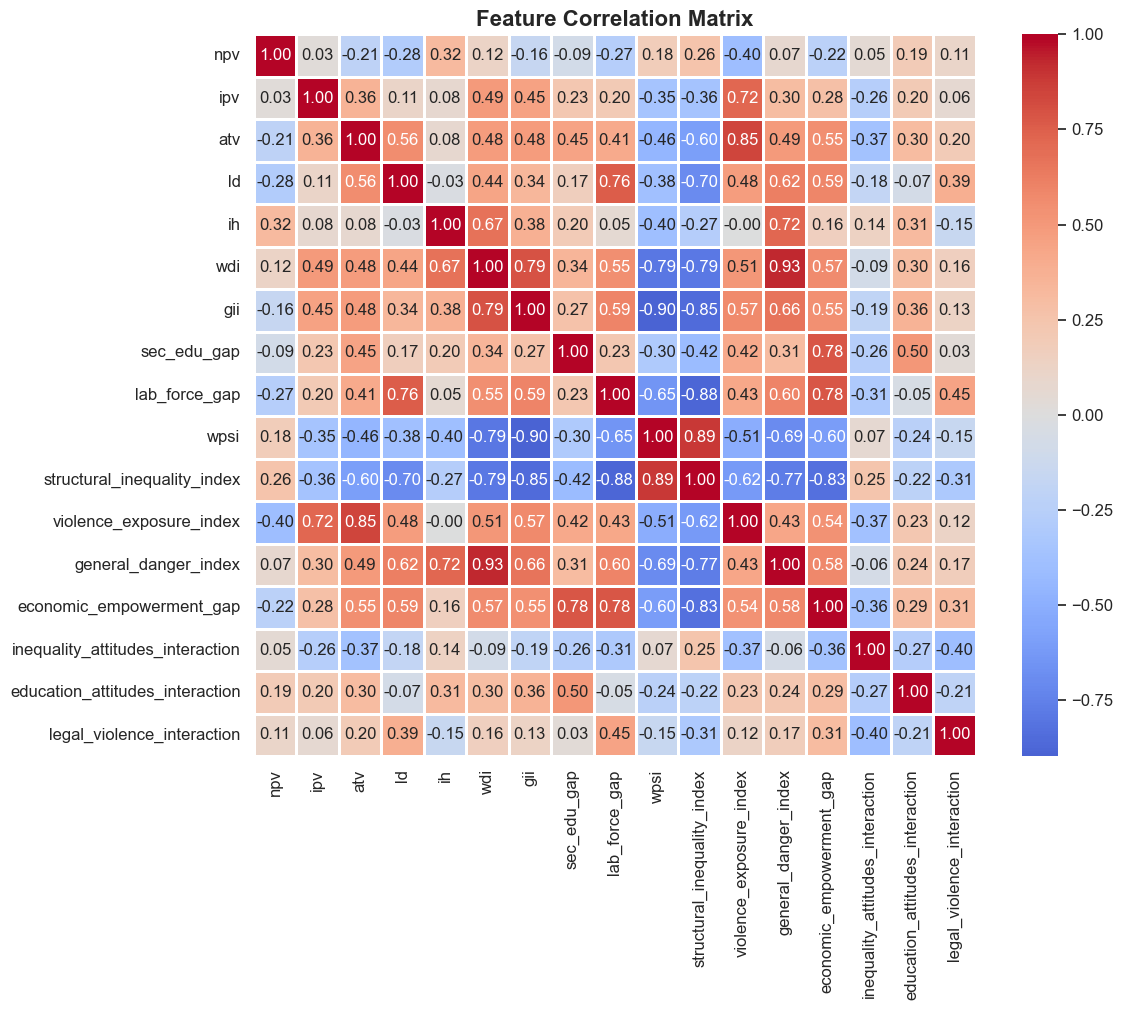

HIGH CORRELATIONS (|r| > 0.7):
ipv ↔ violence_exposure_index: 0.722
atv ↔ violence_exposure_index: 0.849
ld ↔ lab_force_gap: 0.758
ih ↔ general_danger_index: 0.724
wdi ↔ gii: 0.794
wdi ↔ wpsi: -0.793
wdi ↔ structural_inequality_index: -0.786
wdi ↔ general_danger_index: 0.929
gii ↔ wpsi: -0.896
gii ↔ structural_inequality_index: -0.854
sec_edu_gap ↔ economic_empowerment_gap: 0.785
lab_force_gap ↔ structural_inequality_index: -0.877
lab_force_gap ↔ economic_empowerment_gap: 0.785
wpsi ↔ structural_inequality_index: 0.885
structural_inequality_index ↔ general_danger_index: -0.770
structural_inequality_index ↔ economic_empowerment_gap: -0.825

STRUCTURAL INEQUALITY INDEX
Variance explained: 0.589

Component loadings:
  gii: -0.498
  wpsi: 0.516
  sec_edu_gap: -0.244
  lab_force_gap: -0.511
  ld: -0.407

VIOLENCE EXPOSURE INDEX
Variance explained: 0.469

Component loadings:
  ipv: 0.609
  npv: -0.341
  atv: 0.716

FEATURE IMPORTANCE FOR PREDICTING: IPV

Mutual Information Scores:
  violence

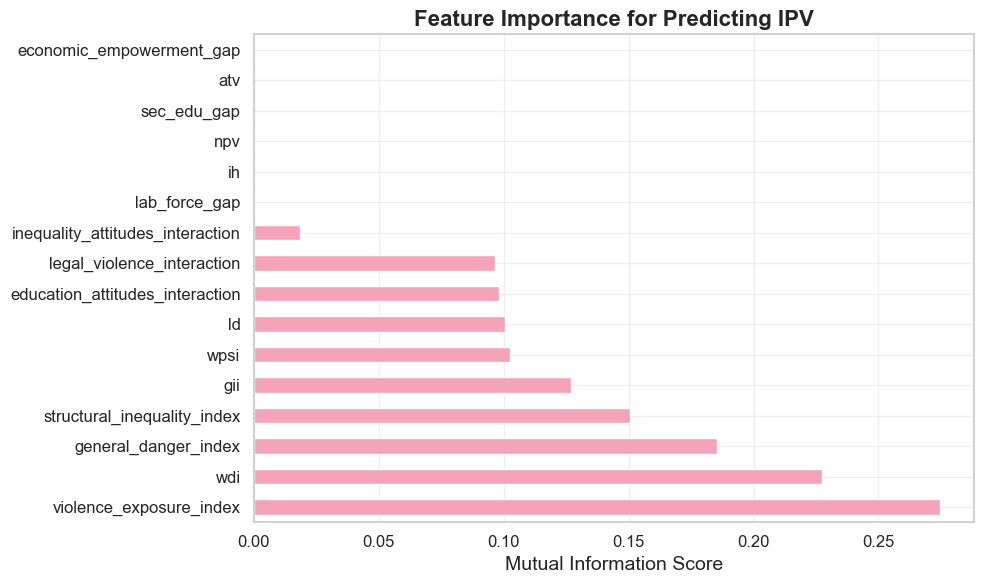


MODELING DATASET PREPARED
Target variable: ipv
Number of features: 14
Features: ['gii', 'sec_edu_gap', 'lab_force_gap', 'ld', 'ih', 'wdi', 'npv', 'atv', 'structural_inequality_index', 'general_danger_index', 'economic_empowerment_gap', 'inequality_attitudes_interaction', 'education_attitudes_interaction', 'legal_violence_interaction']

Dataset shape: (50, 14)
Target distribution:
count    50.00
mean     51.84
std      21.39
min      14.00
25%      32.25
50%      48.00
75%      65.50
max     100.00
Name: ipv, dtype: float64


In [76]:
# all features
violence_df_final_all = full_pipeline(violence_df, use_composite_only=False)

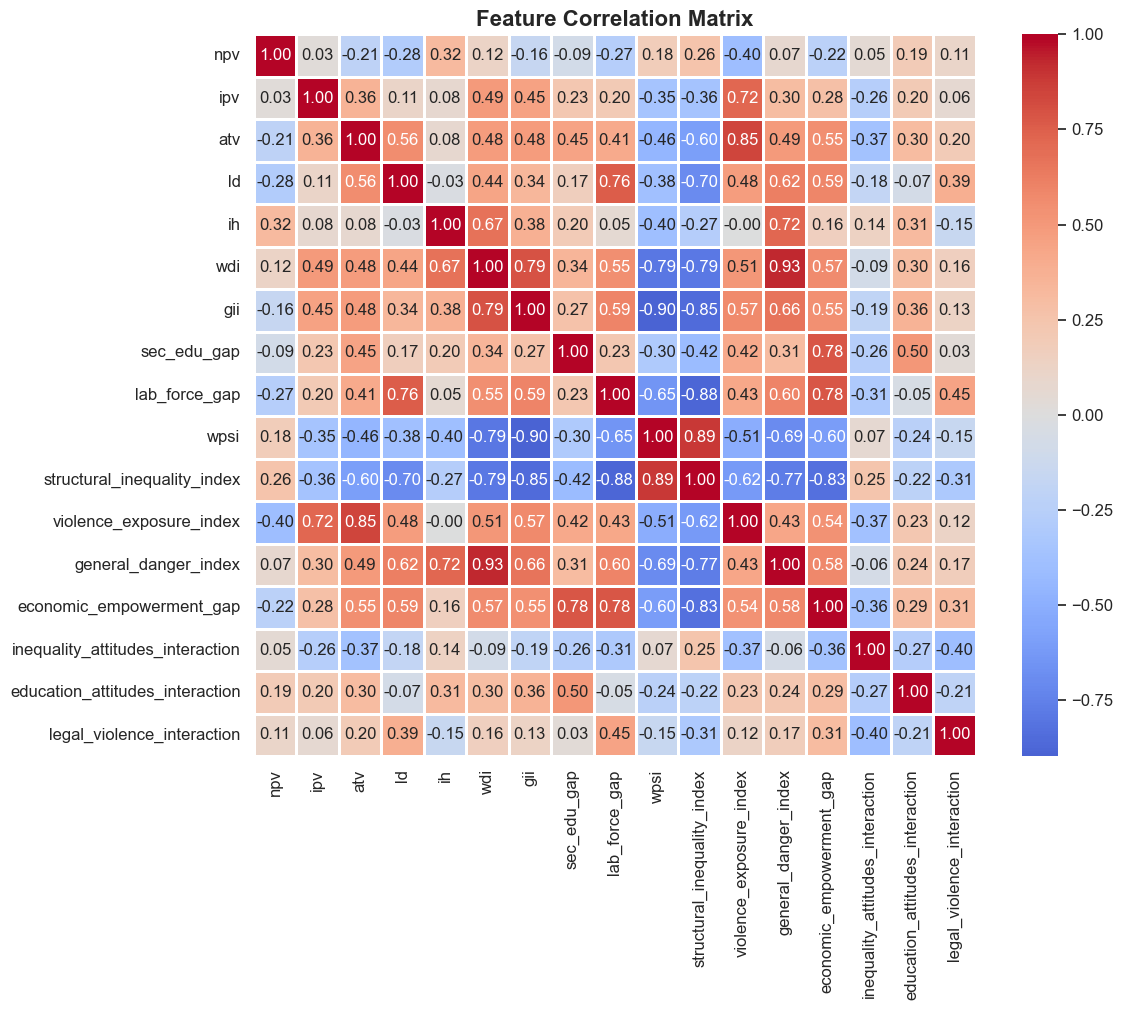

HIGH CORRELATIONS (|r| > 0.7):
ipv ↔ violence_exposure_index: 0.722
atv ↔ violence_exposure_index: 0.849
ld ↔ lab_force_gap: 0.758
ih ↔ general_danger_index: 0.724
wdi ↔ gii: 0.794
wdi ↔ wpsi: -0.793
wdi ↔ structural_inequality_index: -0.786
wdi ↔ general_danger_index: 0.929
gii ↔ wpsi: -0.896
gii ↔ structural_inequality_index: -0.854
sec_edu_gap ↔ economic_empowerment_gap: 0.785
lab_force_gap ↔ structural_inequality_index: -0.877
lab_force_gap ↔ economic_empowerment_gap: 0.785
wpsi ↔ structural_inequality_index: 0.885
structural_inequality_index ↔ general_danger_index: -0.770
structural_inequality_index ↔ economic_empowerment_gap: -0.825

STRUCTURAL INEQUALITY INDEX
Variance explained: 0.589

Component loadings:
  gii: -0.498
  wpsi: 0.516
  sec_edu_gap: -0.244
  lab_force_gap: -0.511
  ld: -0.407

VIOLENCE EXPOSURE INDEX
Variance explained: 0.469

Component loadings:
  ipv: 0.609
  npv: -0.341
  atv: 0.716

FEATURE IMPORTANCE FOR PREDICTING: IPV

Mutual Information Scores:
  violence

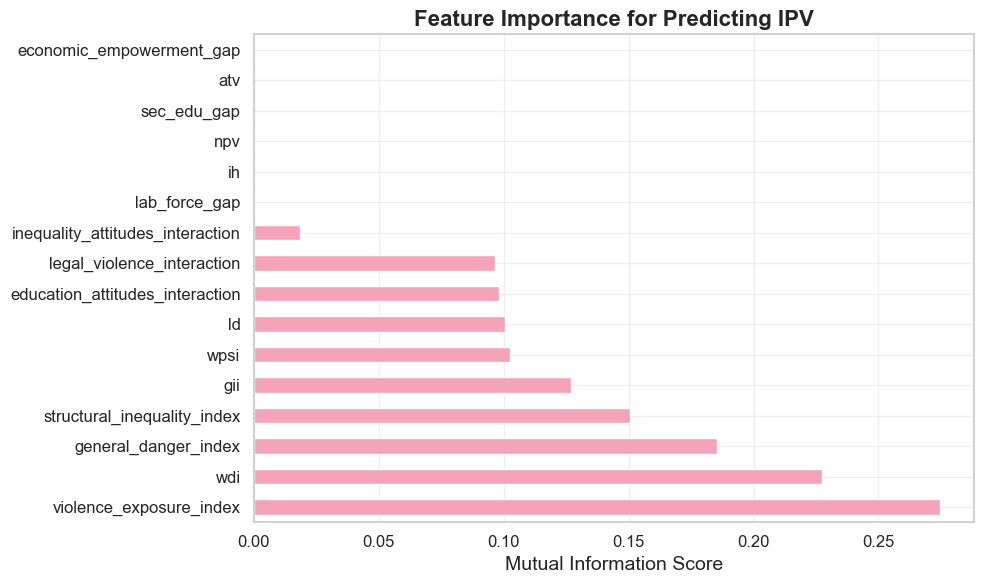


MODELING DATASET PREPARED
Target variable: ipv
Number of features: 7
Features: ['structural_inequality_index', 'violence_exposure_index', 'general_danger_index', 'economic_empowerment_gap', 'inequality_attitudes_interaction', 'education_attitudes_interaction', 'legal_violence_interaction']

Dataset shape: (50, 7)
Target distribution:
count    50.00
mean     51.84
std      21.39
min      14.00
25%      32.25
50%      48.00
75%      65.50
max     100.00
Name: ipv, dtype: float64


In [ ]:
# composite features only
violence_df_final_fe = full_pipeline(violence_df, use_composite_only=True)

In [89]:
violence_df_final_all.to_csv(FEATENG_DIR / "violence_df_final_all", index=False)
violence_df_final_fe.to_csv(FEATENG_DIR / "violence_df_final_fe", index=False)

AttributeError: 'tuple' object has no attribute 'to_csv'

## 5. Global Dataset

In [91]:
global_df.head()

,country,log_GDP,income_category,pf_score,ef_score,gug_15-24,gug_25+,gug_under15,gii,maternal_mortality,adolescent_birth_rate,seats_parliament,human_development_encoded,sec_edu_gap,lab_force_gap,percent_leg_equ_achiev_marriage,ip_violence,wpsi
0,Aruba,9.39,Low Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,11.96,Low Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,10.30,Low Income,NaN,NaN,13.56,15.21,15.66,0.68,638.00,82.60,27.20,1.00,8.50,51.70,NaN,46.00,0.29
3,Africa Western and Central,11.89,Low Income,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,10.77,Low Income,6.02,5.91,-3.89,1.59,0.21,0.54,241.00,138.40,29.50,2.00,23.30,5.10,NaN,38.00,0.60


In [92]:
global_df.nunique()

country                            259
log_GDP                            257
income_category                      1
pf_score                           147
ef_score                           131
gug_15-24                          187
gug_25+                            186
gug_under15                        186
gii                                151
maternal_mortality                 115
adolescent_birth_rate              176
seats_parliament                   157
human_development_encoded            4
sec_edu_gap                        142
lab_force_gap                      152
percent_leg_equ_achiev_marriage     11
ip_violence                         41
wpsi                               147
dtype: int64